In [6]:
import sys
import os
from tempfile import NamedTemporaryFile
from gc import collect

import netCDF4
import h5py
import numpy as np
import pylab as pl

sys.path.append('../util')
from meters import ThroughputMeter, clear_host_cache
from ncgen import *
from grids import *

In [7]:
def write_netcdf_file(timescale, time_major=True):
    print("Creating a time-{} NetCDF file with {}x{} grid and {} time steps".format('major' if time_major else 'minor', grid['lon']['count'], grid['lat']['count'],len(timescale)))
    with NamedTemporaryFile(suffix='.nc', delete=False, dir='../tmp') as f:
        nc = get_base_nc(f.name, world_125k)
        nc = add_simple_time(nc, timescale)
        nc = add_climo_data(nc, 'var_0', timemajor=time_major)
        nc.close()
    print("file size: {}".format(os.path.getsize(f.name)))
    return f

In [16]:
def netcdf4_read_test(f):
    print("Reading out with python-netCDF4 module...")
    results = []
    # Open the file just created
    nc = netCDF4.Dataset(f.name, 'r')
    with ThroughputMeter() as t:
        for i in range(nc.variables['var_0'].shape[0]):
            a = nc.variables['var_0'][i,:,:]
    results.append((len(timescale), t.megabytes_per_second(nc.variables['var_0'])))
    # python-netCDF4 seems to leak file descriptors
    # We have to take a lot of steps to make sure that the files get closed and that
    # the space gets reclaimed by the OS
    nc.close
    return results

In [17]:
def hdf5_read_test(f):
    print("Reading out with h5py module...")
    results = []
    # Open the file just created
    nc = h5py.File(f.name, 'r')
    with ThroughputMeter() as t:
        for i in range(nc['var_0'].shape[0]):
            a = nc['var_0'][i,:,:]
    results.append((len(timescale), t.megabytes_per_second(nc['var_0'])))
    # python-netCDF4 seems to leak file descriptors
    # We have to take a lot of steps to make sure that the files get closed and that
    # the space gets reclaimed by the OS
    nc.close
    return results

### Use world_125k grid at monthly timescale to test read throughput via h5py, followed by via python-netcdf4:

In [30]:
grid = world_125k
timescale = timescales['monthly']
time_major = True
testfile = write_netcdf_file(timescale, time_major)

Creating a time-major NetCDF file with 256x128 grid and 1800 time steps
file size: 235945088


In [31]:
for read_with_h5py in [True, False]:
    !sync
    clear_host_cache()
    if read_with_h5py:
        results_world_125k_monthly_hdf5_read = hdf5_read_test(testfile)
    else:
        results_world_125k_monthly_netcdf4_read = netcdf4_read_test(testfile)
print("Removing {}".format(testfile.name))
os.remove(testfile.name)
testfile.close()
del testfile
collect()

host cache cleared
Reading out with h5py module...
225.000 MB in 1.33 seconds at 169.320 MB / sec
host cache cleared
Reading out with python-netCDF4 module...
225.000 MB in 1.21 seconds at 185.701 MB / sec
Removing /app/tmp/tmp_hhwfkfc.nc


91

In [32]:
results_world_125k_monthly_hdf5_read

[(1800, 169.32021332100851)]

In [33]:
results_world_125k_monthly_netcdf4_read

[(1800, 185.70064074031657)]

### And with canada_5k grid at monthly timescale:

In [28]:
grid = canada_5k
timescale = timescales['monthly']
time_major = True
testfile = write_netcdf_file(timescale, time_major)

Creating a time-major NetCDF file with 1068x510 grid and 1800 time steps
file size: 235945088


In [29]:
for read_with_h5py in [True, False]:
    !sync
    clear_host_cache()
    if read_with_h5py:
        results_canada_5k_monthly_hdf5_read = hdf5_read_test(testfile)
    else:
        results_canada_5k_monthly_netcdf4_read = netcdf4_read_test(testfile)
print("Removing {}".format(testfile.name))
os.remove(testfile.name)
testfile.close()
del testfile
collect()

host cache cleared
Reading out with h5py module...
225.000 MB in 1.33 seconds at 168.890 MB / sec
host cache cleared
Reading out with python-netCDF4 module...
225.000 MB in 1.21 seconds at 185.537 MB / sec
Removing /app/tmp/tmpnxn9d7x9.nc


249

In [38]:
results_canada_5k_monthly_hdf5_read

[(1800, 168.8903794492137)]

In [39]:
results_canada_5k_monthly_netcdf4_read

[(1800, 185.53711623495772)]

### And with canada_5k grid at daily timescale:

In [34]:
grid = canada_5k
timescale = timescales['daily']
time_major = True
testfile = write_netcdf_file(timescale, time_major)

Creating a time-major NetCDF file with 1068x510 grid and 54787 time steps
file size: 7181269100


In [35]:
for read_with_h5py in [True, False]:
    !sync
    clear_host_cache()
    if read_with_h5py:
        results_canada_5k_daily_hdf5_read = hdf5_read_test(testfile)
    else:
        results_canada_5k_daily_netcdf4_read = netcdf4_read_test(testfile)
print("Removing {}".format(testfile.name))
os.remove(testfile.name)
testfile.close()
del testfile
collect()

host cache cleared
Reading out with h5py module...
6848.375 MB in 36.4 seconds at 188.309 MB / sec
host cache cleared
Reading out with python-netCDF4 module...
6848.375 MB in 36.2 seconds at 189.208 MB / sec
Removing /app/tmp/tmpqzz281xn.nc


91

In [36]:
results_canada_5k_daily_hdf5_read

[(54787, 188.3093597757545)]

In [37]:
results_canada_5k_daily_netcdf4_read

[(54787, 189.20844933212683)]

###And with bc_400m grid at monthly timescale:

In [40]:
grid = bc_400m
timescale = timescales['monthly']
time_major = True
testfile = write_netcdf_file(timescale, time_major)

Creating a time-major NetCDF file with 1680x3241 grid and 1800 time steps
file size: 235945088


In [41]:
for read_with_h5py in [True, False]:
    !sync
    clear_host_cache()
    if read_with_h5py:
        results_bc_400m_monthly_hdf5_read = hdf5_read_test(testfile)
    else:
        results_bc_400m_monthly_netcdf4_read = netcdf4_read_test(testfile)
print("Removing {}".format(testfile.name))
os.remove(testfile.name)
testfile.close()
del testfile
collect()

host cache cleared
Reading out with h5py module...
225.000 MB in 1.32 seconds at 170.284 MB / sec
host cache cleared
Reading out with python-netCDF4 module...
225.000 MB in 1.2 seconds at 187.558 MB / sec
Removing /app/tmp/tmp81x1rd7_.nc


104

In [42]:
results_bc_400m_monthly_hdf5_read

[(1800, 170.2842845844753)]

In [43]:
results_bc_400m_monthly_netcdf4_read

[(1800, 187.55819964333435)]

### And with bc_400m grid at daily timescale:

In [44]:
grid = bc_400m
timescale = timescales['daily']
time_major = True
testfile = write_netcdf_file(timescale, time_major)

Creating a time-major NetCDF file with 1680x3241 grid and 54787 time steps
file size: 7181269100


In [45]:
for read_with_h5py in [True, False]:
    !sync
    clear_host_cache()
    if read_with_h5py:
        results_bc_400m_daily_hdf5_read = hdf5_read_test(testfile)
    else:
        results_bc_400m_daily_netcdf4_read = netcdf4_read_test(testfile)
print("Removing {}".format(testfile.name))
os.remove(testfile.name)
testfile.close()
del testfile
collect()

host cache cleared
Reading out with h5py module...
6848.375 MB in 36.7 seconds at 186.847 MB / sec
host cache cleared
Reading out with python-netCDF4 module...
6848.375 MB in 36.3 seconds at 188.917 MB / sec
Removing /app/tmp/tmp0ys9crgx.nc


91

In [46]:
results_bc_400m_daily_hdf5_read

[(54787, 186.84716548009149)]

In [47]:
results_bc_400m_daily_netcdf4_read

[(54787, 188.91707143775659)]

## Summarize Results

In [52]:
grid_sizes = ['world_125k_mon', 'canada_5k_mon', 'canada_5k_day', 'bc_400m_mon', 'bc_400m_day']

hdf5_read_throughput = [results_world_125k_monthly_hdf5_read, results_canada_5k_monthly_hdf5_read, \
                        results_canada_5k_daily_hdf5_read, results_bc_400m_monthly_hdf5_read, \
                        results_bc_400m_daily_hdf5_read]

netcdf4_read_throughput = [results_world_125k_monthly_netcdf4_read, results_canada_5k_monthly_netcdf4_read, \
                           results_canada_5k_daily_netcdf4_read, results_bc_400m_monthly_netcdf4_read, \
                           results_bc_400m_daily_netcdf4_read]

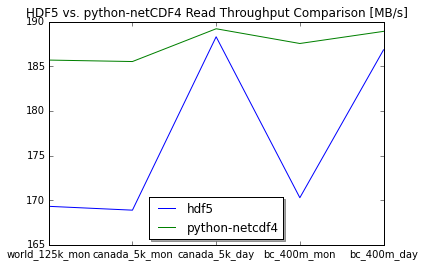

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
hdf5_read, = plt.plot([point[0][1] for point in hdf5_read_throughput], label='hdf5')
netcdf4_read, = plt.plot([point[0][1] for point in netcdf4_read_throughput], label='python-netcdf4')
plt.xticks(range(len(grid_sizes)), grid_sizes)
plt.title('HDF5 vs. python-netCDF4 Read Throughput Comparison [MB/s]')
plt.legend(loc='lower center', shadow=True)
plt.show()

### NetCDF file readout using python-netcdf4 is generally faster than with hdf5